THIS NOTEBOOK IS TO PREDICT IF COUNTRY'S ECONIMICAL FACTOR HELP COUNTRIES TO WIN LOW,MEDIUM OR HIGH NUMBER OF MEDALS.

In [1]:
!pip install xgboost
!pip install imblearn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import sklearn.ensemble
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy import stats
from scipy.stats import norm
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import OrdinalClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve, classification_report, precision_recall_curve
import xgboost
from xgboost import XGBClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import imblearn
import collections
from sklearn.metrics import matthews_corrcoef
import statsmodels.api as sm
import pylab as py

  Using cached xgboost-1.4.2-py3-none-manylinux2010_x86_64.whl (166.7 MB)
  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.8.0-py3-none-any.whl (206 kB)
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Using cached threadpoolctl-2.2.0-py3-none-any.whl (12 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


Reading  Events and regions file and merging them

In [2]:
events=pd.read_csv("/home/jovyan/athlete_events.csv") 
regions=pd.read_csv("/home/jovyan/noc_regions.csv")
olympics = pd.merge(events, regions, on="NOC", how="left") 
print(olympics.head(),olympics.shape)

   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal       region notes  
0       Basketball Men's Basketball   NaN        China   NaN  
1      Judo Men's Extra-Lightwei

Filtering the Dataset to include only Summer data

In [3]:
Summer_olympics=olympics[(olympics.Season=='Summer') & (olympics.Year!=1906)]

Now preparing the Dataset to merge with GDP and Population data 

In [4]:
## filling the NaN values of column 'Region' by taking the values from 'Team' 
Summer_olympics["region"].fillna(Summer_olympics["Team"], inplace=True)
Summer_olympics.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 220819 entries, 0 to 271110
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      220819 non-null  int64  
 1   Name    220819 non-null  object 
 2   Sex     220819 non-null  object 
 3   Age     212373 non-null  float64
 4   Height  170438 non-null  float64
 5   Weight  168493 non-null  float64
 6   Team    220819 non-null  object 
 7   NOC     220819 non-null  object 
 8   Games   220819 non-null  object 
 9   Year    220819 non-null  int64  
 10  Season  220819 non-null  object 
 11  City    220819 non-null  object 
 12  Sport   220819 non-null  object 
 13  Event   220819 non-null  object 
 14  Medal   33630 non-null   object 
 15  region  220819 non-null  object 
 16  notes   4361 non-null    object 
dtypes: float64(3), int64(2), object(12)
memory usage: 30.3+ MB


Just selecting the required columns now

In [5]:
Summer_olympics = Summer_olympics[["NOC","Sex","Year", "City", "Medal","region"]]
Summer_olympics.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 220819 entries, 0 to 271110
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   NOC     220819 non-null  object
 1   Sex     220819 non-null  object
 2   Year    220819 non-null  int64 
 3   City    220819 non-null  object
 4   Medal   33630 non-null   object
 5   region  220819 non-null  object
dtypes: int64(1), object(5)
memory usage: 11.8+ MB


In [6]:
#change faulty country code values.
faulty_codes_dict = {"MAS": "MAL", "NBO": "MAL",
                    "TCH": "CZE",
                    "YUG": "SRB", "SCG": "SRB",
                    "TTO": "TRI", "WIF": "TRI",
                    "SAA": "GER", "GDR": "GER",
                    "URS": "RUS", "EUN": "RUS",
                    "VNM": "VIE",
                    "RHO": "ZIM",
                    "UAR": "SYR",
                    "YAR": "YEM", "YMD": "YEM",
                    "SSD": "SUD"}

Summer_olympics = Summer_olympics.replace(to_replace = faulty_codes_dict)

#sort by year and country
Summer_olympics = Summer_olympics.sort_values(by = ["Year", "NOC"])
Summer_olympics = Summer_olympics.reset_index(drop = True)
Summer_olympics.head()

,NOC,Sex,Year,City,Medal,region
0,AUS,M,1896,Athina,NaN,Australia
1,AUS,M,1896,Athina,Bronze,Australia
2,AUS,M,1896,Athina,Gold,Australia
3,AUS,M,1896,Athina,Gold,Australia
4,AUS,M,1896,Athina,NaN,Australia


Check if there are any null values in the columns

In [7]:
Summer_olympics.isnull().any()

NOC       False
Sex       False
Year      False
City      False
Medal      True
region    False
dtype: bool

Medal column has null values. We will be replacing it with the value 0

In [8]:
Summer_olympics["Medal"].fillna(value = 0, inplace = True)
Summer_olympics.head()

,NOC,Sex,Year,City,Medal,region
0,AUS,M,1896,Athina,0,Australia
1,AUS,M,1896,Athina,Bronze,Australia
2,AUS,M,1896,Athina,Gold,Australia
3,AUS,M,1896,Athina,Gold,Australia
4,AUS,M,1896,Athina,0,Australia


Sorting the dataset by Year and then NOC

In [9]:
#sort by year and country
Summer_olympics = Summer_olympics.sort_values(by = ["Year", "NOC"])
Summer_olympics = Summer_olympics.reset_index(drop = True)
Summer_olympics.head()

,NOC,Sex,Year,City,Medal,region
0,AUS,M,1896,Athina,0,Australia
1,AUS,M,1896,Athina,Bronze,Australia
2,AUS,M,1896,Athina,Gold,Australia
3,AUS,M,1896,Athina,Gold,Australia
4,AUS,M,1896,Athina,0,Australia


Creating a new column for total participation 

In [10]:
## participation by country
participants_count=Summer_olympics.groupby(['Year','NOC'])["NOC"].count().reset_index(name="Total Participants")
participants_count.head()


## merging this with our main data set calledSummer_olympics
Summer_olympics = pd.merge(Summer_olympics,participants_count,on=['NOC','Year'],how="left")
Summer_olympics.head(10)

,NOC,Sex,Year,City,Medal,region,Total Participants
0,AUS,M,1896,Athina,0,Australia,5
1,AUS,M,1896,Athina,Bronze,Australia,5
2,AUS,M,1896,Athina,Gold,Australia,5
3,AUS,M,1896,Athina,Gold,Australia,5
4,AUS,M,1896,Athina,0,Australia,5
5,AUT,M,1896,Athina,Silver,Austria,8
6,AUT,M,1896,Athina,Gold,Austria,8
7,AUT,M,1896,Athina,0,Austria,8
8,AUT,M,1896,Athina,Bronze,Austria,8
9,AUT,M,1896,Athina,0,Austria,8


Medal Tally: Medal tally is the sum of all medals won.

In [11]:
# creating  new df medal
medal = Summer_olympics.groupby(['Year','NOC','Medal']).size().unstack('Medal',fill_value=0)
medal['Total Medal'] = medal['Gold'] +medal['Silver'] +medal['Bronze'] 
medal

# merging this with our main data set called olympics_complete
Summer_olympics = pd.merge(Summer_olympics,medal,on=['NOC','Year'],how="left")
Summer_olympics.head()



,NOC,Sex,Year,City,Medal,region,Total Participants,0,Bronze,Gold,Silver,Total Medal
0,AUS,M,1896,Athina,0,Australia,5,2,1,2,0,3
1,AUS,M,1896,Athina,Bronze,Australia,5,2,1,2,0,3
2,AUS,M,1896,Athina,Gold,Australia,5,2,1,2,0,3
3,AUS,M,1896,Athina,Gold,Australia,5,2,1,2,0,3
4,AUS,M,1896,Athina,0,Australia,5,2,1,2,0,3


In [12]:
Summer_olympics = Summer_olympics[["NOC","Year","City","region","Total Participants","Bronze","Gold","Silver","Total Medal"]]

In [13]:
Summer_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220819 entries, 0 to 220818
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   NOC                 220819 non-null  object
 1   Year                220819 non-null  int64 
 2   City                220819 non-null  object
 3   region              220819 non-null  object
 4   Total Participants  220819 non-null  int64 
 5   Bronze              220819 non-null  int64 
 6   Gold                220819 non-null  int64 
 7   Silver              220819 non-null  int64 
 8   Total Medal         220819 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 16.8+ MB


Once we have the toal participation, lets remove the duplicate rows.

In [14]:
Summer_olympics= Summer_olympics.drop_duplicates()
Summer_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2813 entries, 0 to 220788
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   NOC                 2813 non-null   object
 1   Year                2813 non-null   int64 
 2   City                2813 non-null   object
 3   region              2813 non-null   object
 4   Total Participants  2813 non-null   int64 
 5   Bronze              2813 non-null   int64 
 6   Gold                2813 non-null   int64 
 7   Silver              2813 non-null   int64 
 8   Total Medal         2813 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 219.8+ KB


AS WE ARE TRYING TO SEE WHICH CATEGORY (LOW,MEDIUM or HIGH) A COUNTRY FALLS INTO, LEST ONLY CONSIDER THE COUNTRIES WHO HAVE WON MEDALS AND REMOVE THOSE WHO HAVE ZERO MEDALS.

In [15]:
# lets consider only those countries who have won the medals
Summer_olympics = Summer_olympics[(Summer_olympics['Total Medal']!=0)]
Summer_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1280 entries, 0 to 220746
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   NOC                 1280 non-null   object
 1   Year                1280 non-null   int64 
 2   City                1280 non-null   object
 3   region              1280 non-null   object
 4   Total Participants  1280 non-null   int64 
 5   Bronze              1280 non-null   int64 
 6   Gold                1280 non-null   int64 
 7   Silver              1280 non-null   int64 
 8   Total Medal         1280 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 100.0+ KB


Lets Merge this data with population and GDP

In [16]:
#Reading GDP data
#The columns are the years for which the GDP has been recorded. This needs to brought into a single column for efficient merging.
w_gdp = pd.read_csv("/home/jovyan/world_gdp.csv", skiprows = 3)
# Remove unnecessary columns
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


In [17]:
print(w_gdp.isnull().sum())

Country Name       0
Country Code       0
Year               0
GDP             3225
dtype: int64


In [18]:
sort = w_gdp.sort_values(['Year'])
sort.head(10)

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
140,Netherlands,NLD,1960,1.227673e+10
141,New Caledonia,NCL,1960,NaN
142,New Zealand,NZL,1960,5.485855e+09
143,Nicaragua,NIC,1960,NaN
144,Niger,NER,1960,4.495269e+08
145,Nigeria,NGA,1960,4.196092e+09
146,Northern Mariana Islands,MNP,1960,NaN
147,Norway,NOR,1960,5.163272e+09
148,Not classified,INX,1960,NaN


In [19]:
# as the GDP data is from 1960, lets first consider only the data from 1960 for olympics
Summer_olympics=Summer_olympics[Summer_olympics.Year >= 1960]
Summer_olympics.head()

,NOC,Year,City,region,Total Participants,Bronze,Gold,Silver,Total Medal
54573,ARG,1960,Roma,Argentina,116,1,0,3,4
54689,AUS,1960,Roma,Australia,280,11,11,24,46
54969,AUT,1960,Roma,Austria,198,0,1,2,3
55181,BEL,1960,Roma,Belgium,150,2,0,2,4
55340,BRA,1960,Roma,Brazil,86,13,0,0,13


In [20]:
Summer_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 908 entries, 54573 to 220746
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   NOC                 908 non-null    object
 1   Year                908 non-null    int64 
 2   City                908 non-null    object
 3   region              908 non-null    object
 4   Total Participants  908 non-null    int64 
 5   Bronze              908 non-null    int64 
 6   Gold                908 non-null    int64 
 7   Silver              908 non-null    int64 
 8   Total Medal         908 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 70.9+ KB


In [21]:
#lets check if we need to merge using the column country code. All NOC in Summer Olympics data is not present in GDP data.
len(list(set(olympics['NOC'].unique()) - set(w_gdp['Country Code'].unique())))

108

In [22]:
# as All the NOC in the Summer Olympics dataset is not present in the country code in the GDP data,lets merge using region in Summer Olympics dataset
# and country name in GDP data. 
olympics_merge_ccode = pd.merge(Summer_olympics, w_gdp[['Country Name', 'Country Code']].drop_duplicates(), left_on=['region'],right_on=['Country Name'], how="left")


olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)
olympics_merge_ccode.head()

olympics_merge_gdp = pd.merge(olympics_merge_ccode, w_gdp, on=['Country Code', 'Year'], how="left")

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)
olympics_merge_gdp.head()

,NOC,Year,City,region,Total Participants,Bronze,Gold,Silver,Total Medal,Country Code,GDP
0,ARG,1960,Roma,Argentina,116,1,0,3,4,ARG,NaN
1,AUS,1960,Roma,Australia,280,11,11,24,46,AUS,1.859335e+10
2,AUT,1960,Roma,Austria,198,0,1,2,3,AUT,6.592694e+09
3,BEL,1960,Roma,Belgium,150,2,0,2,4,BEL,1.165872e+10
4,BRA,1960,Roma,Brazil,86,13,0,0,13,BRA,1.516557e+10


Now just lets drop the column NOC as we will be using Country Code for further processing

In [23]:
olympics_merge_gdp= olympics_merge_gdp[["Year","City","region","Total Participants","Bronze","Gold","Silver","Total Medal","Country Code","GDP"]]

In [24]:
#Apart from GDP, population is also of importance when looking at a countries performance as 
#Higher populations mean a bigger talent pool to choose from

w_pop = pd.read_csv('/home/jovyan/world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])

w_pop.head()

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


In [25]:
#merge the Population data
olympics_complete = pd.merge(olympics_merge_gdp, w_pop, on=['Country Code', 'Year'], how="left")
olympics_complete.drop('Country', axis = 1, inplace = True)

olympics_complete.head()

,Year,City,region,Total Participants,Bronze,Gold,Silver,Total Medal,Country Code,GDP,Population
0,1960,Roma,Argentina,116,1,0,3,4,ARG,NaN,20619075.0
1,1960,Roma,Australia,280,11,11,24,46,AUS,1.859335e+10,10276477.0
2,1960,Roma,Austria,198,0,1,2,3,AUT,6.592694e+09,7047539.0
3,1960,Roma,Belgium,150,2,0,2,4,BEL,1.165872e+10,9153489.0
4,1960,Roma,Brazil,86,13,0,0,13,BRA,1.516557e+10,72207554.0


In [26]:
#lets look for the unique city name
olympics_complete[['Year', 'City']].drop_duplicates().sort_values('Year')

,Year,City
0,1960,Roma
45,1964,Tokyo
86,1968,Mexico City
130,1972,Munich
178,1976,Montreal
219,1980,Moskva
255,1984,Los Angeles
302,1988,Seoul
354,1992,Barcelona
418,1996,Atlanta


In [27]:
#correcting Host City's Name 
olympics_complete['City'].replace(['Athina', 'Moskva'], ['Athens', 'Moscow'], inplace = True)

In [28]:
# city to country mapping dictionary
city_to_country = {'Roma': 'Italy',
                   'Tokyo': 'Japan',
                  'Mexico City': 'Mexico',
                  'Munich': 'Germany',
                  'Montreal': 'Canada',
                  'Moscow': 'Russia',
                  'Los Angeles': 'USA',
                  'Seoul': 'South Korea',
                  'Barcelona': 'Spain',
                  'Atlanta': 'USA',
                  'Sydney': 'Australia',
                  'Athens': 'Greece',
                  'Beijing': 'China',
                  'London': 'UK',
                  'Rio de Janeiro': 'Brazil'}

# Creating a new column called Country_Host by mapping the cities to CountryMap cities to countries
olympics_complete['Country_Host'] = olympics_complete['City'].map(city_to_country)

#print the 
olympics_complete.loc[:, ['Year', 'Country_Host']].drop_duplicates().sort_values('Year')
olympics_complete.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 908 entries, 0 to 907
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                908 non-null    int64  
 1   City                908 non-null    object 
 2   region              908 non-null    object 
 3   Total Participants  908 non-null    int64  
 4   Bronze              908 non-null    int64  
 5   Gold                908 non-null    int64  
 6   Silver              908 non-null    int64  
 7   Total Medal         908 non-null    int64  
 8   Country Code        895 non-null    object 
 9   GDP                 805 non-null    float64
 10  Population          886 non-null    float64
 11  Country_Host        908 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 92.2+ KB


In [29]:
#Lets sort the dataset by year and Country
olympics_complete = olympics_complete.sort_values(by = ["Year", "Country Code"])
olympics_complete = olympics_complete.reset_index(drop = True)
olympics_complete.head()
                                                                                                                                                               

,Year,City,region,Total Participants,Bronze,Gold,Silver,Total Medal,Country Code,GDP,Population,Country_Host
0,1960,Roma,Argentina,116,1,0,3,4,ARG,NaN,20619075.0,Italy
1,1960,Roma,Australia,280,11,11,24,46,AUS,1.859335e+10,10276477.0,Italy
2,1960,Roma,Austria,198,0,1,2,3,AUT,6.592694e+09,7047539.0,Italy
3,1960,Roma,Belgium,150,2,0,2,4,BEL,1.165872e+10,9153489.0,Italy
4,1960,Roma,Bulgaria,183,3,1,3,7,BGR,NaN,7867374.0,Italy


In [30]:
## lets put Host value as 1 if the region is same as host country or else 0
olympics_complete.loc[olympics_complete['region'] == olympics_complete['Country_Host'], 'Host'] = 1 
olympics_complete.loc[olympics_complete['region'] != olympics_complete['Country_Host'], 'Host'] = 0
olympics_complete.head()


,Year,City,region,Total Participants,Bronze,Gold,Silver,Total Medal,Country Code,GDP,Population,Country_Host,Host
0,1960,Roma,Argentina,116,1,0,3,4,ARG,NaN,20619075.0,Italy,0.0
1,1960,Roma,Australia,280,11,11,24,46,AUS,1.859335e+10,10276477.0,Italy,0.0
2,1960,Roma,Austria,198,0,1,2,3,AUT,6.592694e+09,7047539.0,Italy,0.0
3,1960,Roma,Belgium,150,2,0,2,4,BEL,1.165872e+10,9153489.0,Italy,0.0
4,1960,Roma,Bulgaria,183,3,1,3,7,BGR,NaN,7867374.0,Italy,0.0


LETS CLEAN THE DATA LITTLE MORE BEFORE WE DO THE SPLITTING

In [31]:
olympics_complete = olympics_complete[["Year","Total Participants","Total Medal","Country Code","GDP","Population","Host"]]
olympics_complete.head()

,Year,Total Participants,Total Medal,Country Code,GDP,Population,Host
0,1960,116,4,ARG,NaN,20619075.0,0.0
1,1960,280,46,AUS,1.859335e+10,10276477.0,0.0
2,1960,198,3,AUT,6.592694e+09,7047539.0,0.0
3,1960,150,4,BEL,1.165872e+10,9153489.0,0.0
4,1960,183,7,BGR,NaN,7867374.0,0.0


In [32]:
# Descriptive Statistics
olympics_complete.describe()
olympics_complete.iloc[:,1:].describe()

,Total Participants,Total Medal,GDP,Population,Host
count,908.000000,908.000000,8.050000e+02,8.860000e+02,908.000000
mean,161.973568,25.931718,4.761656e+11,6.192672e+07,0.017621
std,163.238705,47.402122,1.496767e+12,1.786465e+08,0.131642
min,3.000000,1.000000,2.195836e+08,5.320000e+04,0.000000
25%,44.000000,2.000000,1.633081e+10,5.710584e+06,0.000000
50%,97.500000,7.000000,7.014084e+10,1.526690e+07,0.000000
75%,232.250000,26.000000,2.965360e+11,5.084286e+07,0.000000
max,839.000000,442.000000,1.862450e+13,1.378665e+09,1.000000


In [33]:
olympics_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                908 non-null    int64  
 1   Total Participants  908 non-null    int64  
 2   Total Medal         908 non-null    int64  
 3   Country Code        895 non-null    object 
 4   GDP                 805 non-null    float64
 5   Population          886 non-null    float64
 6   Host                908 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 49.8+ KB


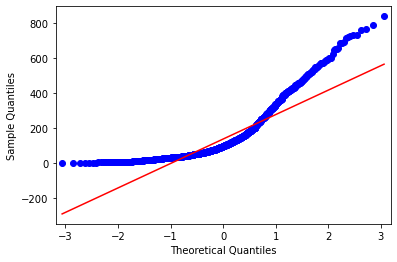

In [34]:
# lets check if the data meets the requirement of Linear Regression
sm.qqplot(olympics_complete['Total Participants'],line="q")
py.show()

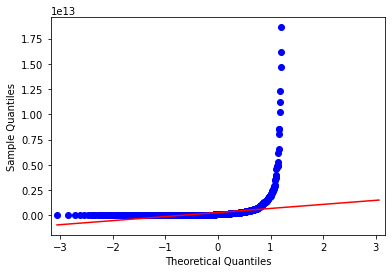

In [35]:
sm.qqplot(olympics_complete['GDP'],line="q")
py.show()

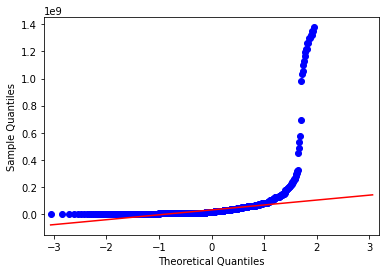

In [36]:
sm.qqplot(olympics_complete['Population'],line="q")
py.show()

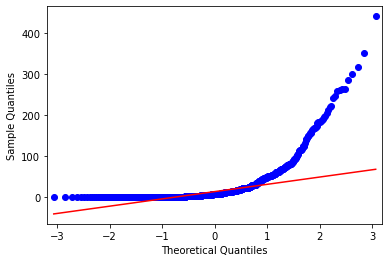

In [37]:
sm.qqplot(olympics_complete['Total Medal'],line="q")
py.show()

In [38]:
olympics_complete['Total Medal'].describe()
pd.qcut(olympics_complete['Total Medal'], q=4)

0         (2.0, 7.0]
1      (26.0, 442.0]
2         (2.0, 7.0]
3         (2.0, 7.0]
4         (2.0, 7.0]
           ...      
903     (0.999, 2.0]
904     (0.999, 2.0]
905      (7.0, 26.0]
906     (0.999, 2.0]
907       (2.0, 7.0]
Name: Total Medal, Length: 908, dtype: category
Categories (4, interval[float64]): [(0.999, 2.0] < (2.0, 7.0] < (7.0, 26.0] < (26.0, 442.0]]

In [39]:
## Binning the orignial dataset into 4 categorical values:
olympics_complete['Medal category']  = pd.qcut(olympics_complete['Total Medal'], q=4,labels=["0", "1", "2","3"])

#LabelEncoder can be used to normalize labels. 
#It can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.
#list(labelencoder.inverse_transform(olympics_complete['Medal category']))
labelencoder = LabelEncoder()
olympics_complete['Medal category'] = labelencoder.fit_transform(olympics_complete['Medal category'])  
olympics_complete['Medal category'].value_counts()

0    261
3    225
2    219
1    203
Name: Medal category, dtype: int64

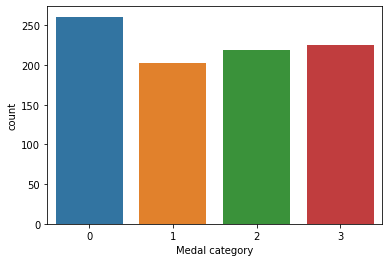

In [40]:
g = sns.countplot(olympics_complete['Medal category'])
g.set_xticklabels(['0','1','2','3'])
plt.show()

In [41]:
olympics_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                908 non-null    int64  
 1   Total Participants  908 non-null    int64  
 2   Total Medal         908 non-null    int64  
 3   Country Code        895 non-null    object 
 4   GDP                 805 non-null    float64
 5   Population          886 non-null    float64
 6   Host                908 non-null    float64
 7   Medal category      908 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 56.9+ KB


In [42]:
olympics_complete = olympics_complete.sort_values(by = ["Year", "Country Code"])
olympics_complete = olympics_complete.reset_index(drop = True)
olympics_complete.head()

,Year,Total Participants,Total Medal,Country Code,GDP,Population,Host,Medal category
0,1960,116,4,ARG,NaN,20619075.0,0.0,1
1,1960,280,46,AUS,1.859335e+10,10276477.0,0.0,3
2,1960,198,3,AUT,6.592694e+09,7047539.0,0.0,1
3,1960,150,4,BEL,1.165872e+10,9153489.0,0.0,1
4,1960,183,7,BGR,NaN,7867374.0,0.0,1


DATASET IS NOW READY. LETS SPLIT THE DATA INTO TRAINING AND TEST SET

In [43]:
data_train = olympics_complete[olympics_complete.Year<2012].reset_index(drop = True)
data_test = olympics_complete[olympics_complete.Year>=2012].reset_index(drop = True)

In [45]:
data_train = data_train.sort_values(by = ["Year", "Country Code"])
data_train = data_train.reset_index(drop = True)
data_test = data_test.sort_values(by = ["Year", "Country Code"])
data_test = data_test.reset_index(drop = True)

In [46]:
data_test.info()
data_train.info()
print("test data percentage: %.3f%%" % (round(171/908* 100.0)))
print("train data percentage: %.3f%%" % (round(737/908 * 100.0)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                171 non-null    int64  
 1   Total Participants  171 non-null    int64  
 2   Total Medal         171 non-null    int64  
 3   Country Code        168 non-null    object 
 4   GDP                 163 non-null    float64
 5   Population          168 non-null    float64
 6   Host                171 non-null    float64
 7   Medal category      171 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 10.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                737 non-null    int64  
 1   Total Participants  737 non-null    int64  
 2   Total Medal         737 non-null    in

In [47]:
print(data_train[['GDP','Population']].skew())

GDP           7.461905
Population    5.993467
dtype: float64


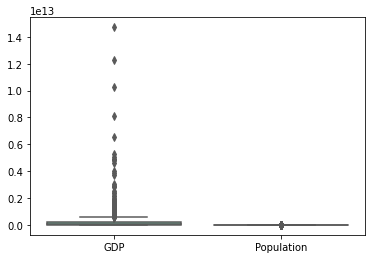

In [48]:
## box Plot
import seaborn as sns
ax = sns.boxplot(data=data_train.iloc[:,4:6],orient="v", palette="Set2")

DATA IMPUTATION : GDP AND POPULATION

In [49]:
#Fill in the NaN values for GDP and Population Size, with the median values of the entire column (as we find the data highly skewed)
import numpy as np
imp_col = ['GDP','Population']
for col in imp_col:
    data_train.loc[:,(col)] = data_train.loc[:,(col)].fillna((data_train.loc[:,(col)].median()))

 #data_train.loc[:,(target)]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                737 non-null    int64  
 1   Total Participants  737 non-null    int64  
 2   Total Medal         737 non-null    int64  
 3   Country Code        727 non-null    object 
 4   GDP                 737 non-null    float64
 5   Population          737 non-null    float64
 6   Host                737 non-null    float64
 7   Medal category      737 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 46.2+ KB


GDP PER CAPITA: Creating a new column called GDP per capita by diving GDP with Population as Its not GDP alone but GDP per capita decides how much resources a country has and its a good predictor value than GDP alone

In [50]:
data_train['GDP Per Capita'] = data_train['GDP']/data_train['Population']
data_train.head()

,Year,Total Participants,Total Medal,Country Code,GDP,Population,Host,Medal category,GDP Per Capita
0,1960,116,4,ARG,5.565836e+10,20619075.0,0.0,1,2699.362658
1,1960,280,46,AUS,1.859335e+10,10276477.0,0.0,3,1809.311452
2,1960,198,3,AUT,6.592694e+09,7047539.0,0.0,1,935.460427
3,1960,150,4,BEL,1.165872e+10,9153489.0,0.0,1,1273.691659
4,1960,183,7,BGR,5.565836e+10,7867374.0,0.0,1,7074.579282


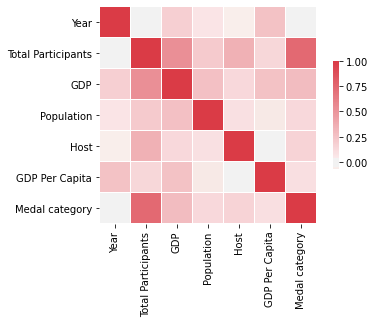

In [51]:
cmap = sns.diverging_palette(20,10, as_cmap=True)
sns.heatmap(data_train[["Year","Total Participants","GDP","Population","Host","GDP Per Capita",'Medal category']].corr(), vmax=1, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink":.5})

Correlation between Response and the Predictors:
GDP and Total Participants impacts the target variable positively and could be a good predictor to determine Medal Category.

In [52]:
predictors = ["Year","Total Participants","GDP","Population","Host","GDP Per Capita"]
X_train = data_train.loc[:,(predictors)].reset_index(drop = True)
Y_train=data_train['Medal category']
print (X_train,Y_train)

     Year  Total Participants           GDP  Population  Host  GDP Per Capita
0    1960                 116  5.565836e+10  20619075.0   0.0     2699.362658
1    1960                 280  1.859335e+10  10276477.0   0.0     1809.311452
2    1960                 198  6.592694e+09   7047539.0   0.0      935.460427
3    1960                 150  1.165872e+10   9153489.0   0.0     1273.691659
4    1960                 183  5.565836e+10   7867374.0   0.0     7074.579282
..    ...                 ...           ...         ...   ...             ...
732  2008                 126  3.159530e+11  28141701.0   0.0    11227.217573
733  2008                  18  9.913030e+10  85118700.0   0.0     1164.612525
734  2008                 179  2.871000e+11  49557573.3   0.0     5793.261875
735  2008                  16  4.415703e+09  13558469.0   0.0      325.678570
736  2008                  92  5.565836e+10  15403885.0   0.0     3613.267763

[737 rows x 6 columns] 0      1
1      3
2      1
3      1
4   

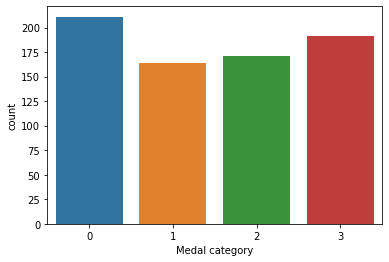

In [53]:
# visualize the target variable
g = sns.countplot(Y_train)
g.set_xticklabels(['0','1','2','3','4'])
plt.show()

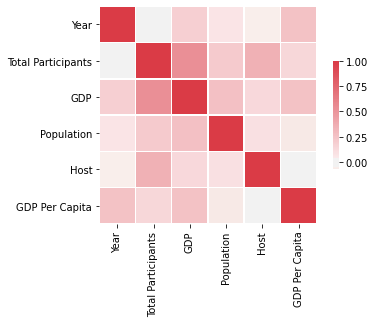

In [54]:
cmap = sns.diverging_palette(20,10, as_cmap=True)
sns.heatmap(X_train[["Year","Total Participants","GDP","Population","Host","GDP Per Capita"]].corr(), vmax=1, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink":.5})

In [55]:
#Shapiro-Wilk Test
stat,p = shapiro(data_train[["Year","Total Participants","GDP","Population","Host","GDP Per Capita"]])
print('Statistics=%.3f, p=%.3f' % (stat,p))

###OBSERVATION: DATA DISTRIBUTION IS NOT NORMAL

Statistics=0.092, p=0.000


In [56]:
predictors = ["Year","Total Participants","GDP","Population","Host","GDP Per Capita"]
X_train = data_train.loc[:,(predictors)].reset_index(drop = True)
Y_train=data_train['Medal category']
print (X_train,Y_train)

     Year  Total Participants           GDP  Population  Host  GDP Per Capita
0    1960                 116  5.565836e+10  20619075.0   0.0     2699.362658
1    1960                 280  1.859335e+10  10276477.0   0.0     1809.311452
2    1960                 198  6.592694e+09   7047539.0   0.0      935.460427
3    1960                 150  1.165872e+10   9153489.0   0.0     1273.691659
4    1960                 183  5.565836e+10   7867374.0   0.0     7074.579282
..    ...                 ...           ...         ...   ...             ...
732  2008                 126  3.159530e+11  28141701.0   0.0    11227.217573
733  2008                  18  9.913030e+10  85118700.0   0.0     1164.612525
734  2008                 179  2.871000e+11  49557573.3   0.0     5793.261875
735  2008                  16  4.415703e+09  13558469.0   0.0      325.678570
736  2008                  92  5.565836e+10  15403885.0   0.0     3613.267763

[737 rows x 6 columns] 0      1
1      3
2      1
3      1
4   

In [57]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200),max_features=4,threshold=-np.inf)
embeded_rf_selector.fit(X_train,Y_train)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

4 selected features
['Total Participants', 'GDP', 'Population', 'GDP Per Capita']


#Random Forests and decision trees, in general, give preference to features with high cardinality.

Tried with different no. of estimators  (20,25,30,35,40) still the same selected features 

In [58]:
##Feature Selection: Recursive Feature Elimination
#X_norm = MinMaxScaler().fit_transform(X_train)
rfe_selector = RFE(estimator=XGBClassifier(use_label_encoder=False), n_features_to_select=4, step=10, verbose=5)
rfe_selector.fit(X_train, Y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)


Fitting estimator with 6 features.
[17:06:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:09:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
4 selected features
['Total Participants', 'GDP', 'Population', 'GDP Per Capita']


[17:09:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


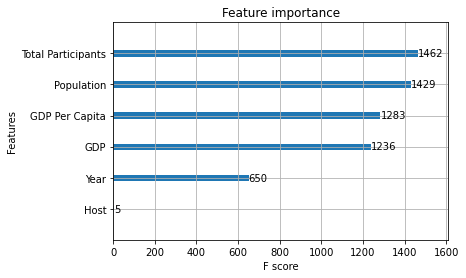

In [59]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
model = XGBClassifier()
model.fit(X_train, Y_train)
# plot feature importance
plot_importance(model)
plt.show()

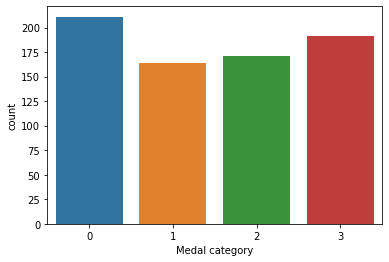

In [60]:
# visualize the target variable
g = sns.countplot(Y_train)
g.set_xticklabels(['0','1','2','3','4'])
plt.show()

PREPARING TEST DATA: Before we Predict lets prepare the Test data first, as I do not want to make any assumptional changes or imputaion, lets drop all the rows in test data which is empty.

In [61]:
data_test = data_test.dropna()
data_test.info()
#create a new cloumn called GDP per Capita
data_test['GDP Per Capita'] = data_test['GDP']/data_test['Population']
data_test = data_test.sort_values(by = ["Year"])
data_test.head(10)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 0 to 168
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                163 non-null    int64  
 1   Total Participants  163 non-null    int64  
 2   Total Medal         163 non-null    int64  
 3   Country Code        163 non-null    object 
 4   GDP                 163 non-null    float64
 5   Population          163 non-null    float64
 6   Host                163 non-null    float64
 7   Medal category      163 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 11.5+ KB


,Year,Total Participants,Total Medal,Country Code,GDP,Population,Host,Medal category,GDP Per Capita
0,2012,6,1,AFG,2.053654e+10,30696958.0,0.0,0,669.009051
60,2012,256,12,POL,5.002840e+11,38063164.0,0.0,2,13143.521122
59,2012,204,27,NZL,1.761930e+11,4408100.0,0.0,3,39970.281981
58,2012,69,17,NOR,5.102290e+11,5018573.0,0.0,2,101668.143514
57,2012,222,69,NLD,8.289470e+11,16754962.0,0.0,3,49474.716803
56,2012,38,2,MYS,3.144430e+11,29170456.0,0.0,0,10779.502384
55,2012,32,5,MNG,1.229277e+10,2814226.0,0.0,1,4368.082247
54,2012,34,14,MNE,4.087725e+09,620601.0,0.0,2,6586.719209
53,2012,119,24,MEX,1.186600e+12,120828307.0,0.0,2,9820.546439
52,2012,20,2,MDA,7.284687e+09,3559519.0,0.0,0,2046.536787


In [62]:
predictors = ["Year","Total Participants","GDP","Population","GDP Per Capita"]
X_test = data_test.loc[:,(predictors)].reset_index(drop = True)
Y_test = data_test['Medal category']
print (X_test,Y_test)

     Year  Total Participants           GDP  Population  GDP Per Capita
0    2012                   6  2.053654e+10  30696958.0      669.009051
1    2012                 256  5.002840e+11  38063164.0    13143.521122
2    2012                 204  1.761930e+11   4408100.0    39970.281981
3    2012                  69  5.102290e+11   5018573.0   101668.143514
4    2012                 222  8.289470e+11  16754962.0    49474.716803
..    ...                 ...           ...         ...             ...
158  2016                  74  1.590490e+11  40606052.0     3916.879188
159  2016                  30  7.158355e+10  10648791.0     6722.223536
160  2016                 143  3.069000e+11   5731118.0    53549.761146
161  2016                  93  3.048190e+11   4773095.0    63861.917687
162  2016                 155  2.954560e+11  55908865.0     5284.600215

[163 rows x 5 columns] 0      0
60     2
59     3
58     2
57     3
      ..
108    0
107    0
106    3
124    1
168    2
Name: Medal c

Lets build and train the Model
1)RandomForest Classifier

In [63]:
# Create Random Forest Classifier object
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train[["Total Participants","GDP","Population","GDP Per Capita","Year"]],Y_train)

start = time.time()
# evaluate on the train dataset
clf_train = clf.predict(X_train[["Total Participants","GDP","Population","GDP Per Capita","Year"]])
train_acc = accuracy_score(Y_train, clf_train)
print("Accuracy_train: %.2f%%" % (train_acc * 100.0))

# evaluate on the test dataset
clf_pred = clf.predict(X_test[["Total Participants","GDP","Population","GDP Per Capita","Year"]]) 
pred_acc = accuracy_score(Y_test, clf_pred)
print("Accuracy_pred: %.2f%%" % (pred_acc * 100.0))
end = time.time()
print(end - start, "seconds")
print(clf)
from pprint import pprint
# Look at parameters used by our current classifier
print('Parameters currently in use:\n')
pprint(clf.get_params())

Accuracy_train: 100.00%
Accuracy_pred: 60.12%
0.04395008087158203 seconds
RandomForestClassifier(random_state=42)
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


We see that our model overfits. The trees perfectly predicts all of the train data, however, it fails to generalize the findings for new data

In [64]:
year_list  = X_train.sort_values(by = ["Year"])
year_list = year_list['Year'].unique()
#year_list = year_list.sort()
print(year_list)


clf1 = RandomForestClassifier(random_state=42)

param_grid = {
                 'n_estimators':range(100,300,10),
                 'max_depth': range(2,60,2)
             }

tscv=TimeSeriesSplit(n_splits=5,max_train_size=None,test_size=2).split(year_list)
grid_clf = GridSearchCV(clf1, param_grid, cv=tscv)
grid_clf.fit(X_train[["Total Participants","GDP","Population","GDP Per Capita","Year"]],Y_train)

start = time.time()
y_predictions = grid_clf.predict(X_test[["Total Participants","GDP","Population","GDP Per Capita","Year"]])
y_train_p=grid_clf.predict(X_train[["Total Participants","GDP","Population","GDP Per Capita","Year"]])
print("accuracy of the test predictions using GRIDSEARCH CLF:", metrics.accuracy_score(Y_test, y_predictions) *100)
print("accuracy of the train predictions using GRIDSEARCH CLF:", metrics.accuracy_score(Y_train, y_train_p)*100)
end = time.time()
print(end - start, "seconds")
pprint(grid_clf.get_params())

[1960 1964 1968 1972 1976 1980 1984 1988 1992 1996 2000 2004 2008]
accuracy of the test predictions using GRIDSEARCH CLF: 57.668711656441715
accuracy of the train predictions using GRIDSEARCH CLF: 67.57123473541384
0.051995038986206055 seconds
{'cv': <generator object TimeSeriesSplit.split at 0x7ff38688b950>,
 'error_score': nan,
 'estimator': RandomForestClassifier(random_state=42),
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 42,
 'estimator__verbose': 0,


https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

In [65]:
print(grid_clf.best_params_)

{'max_depth': 4, 'n_estimators': 160}


In [66]:
# Create Random Forest Classifier object
start = time.time()

# evaluate on the train dataset
grid_clf_train = grid_clf.predict(X_train[["Total Participants","GDP","Population","GDP Per Capita","Year"]])
train_acc = accuracy_score(Y_train, grid_clf_train)
print("Accuracy_train: %.2f%%" % (train_acc * 100.0))

# evaluate on the test dataset
grid_clf_pred = grid_clf.predict(X_test[["Total Participants","GDP","Population","GDP Per Capita",'Year']]) 
pred_acc = accuracy_score(Y_test, grid_clf_pred)
print("Accuracy_pred: %.2f%%" % (pred_acc * 100.0))
end = time.time()
print(end - start, "seconds")
RF_time = end - start

Accuracy_train: 67.57%
Accuracy_pred: 57.67%
0.05279970169067383 seconds


In [67]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test,grid_clf_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(Y_test, grid_clf_pred))
print('\n')
print("=== All Train AUC Scores ===")
print(metrics.accuracy_score(Y_train,  grid_clf_train)*100)
print('\n')
print("=== All Test AUC Scores ===")
print(metrics.accuracy_score(Y_test, grid_clf_pred)*100)

=== Confusion Matrix ===
[[29 18  0  0]
 [ 8 27  0  0]
 [ 5 26 10  6]
 [ 0  1  5 28]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.69      0.62      0.65        47
           1       0.38      0.77      0.50        35
           2       0.67      0.21      0.32        47
           3       0.82      0.82      0.82        34

    accuracy                           0.58       163
   macro avg       0.64      0.61      0.58       163
weighted avg       0.64      0.58      0.56       163



=== All Train AUC Scores ===
67.57123473541384


=== All Test AUC Scores ===
57.668711656441715


In [68]:
CM1 = confusion_matrix(Y_test, grid_clf_pred)
CM1

array([[29, 18,  0,  0],
       [ 8, 27,  0,  0],
       [ 5, 26, 10,  6],
       [ 0,  1,  5, 28]])

In [69]:
TruePositive = np.diag(CM1)
TruePositive

array([29, 27, 10, 28])

In [70]:
#The False Positives are the sum of the respective columns, minus the diagonal element:(Type 1 error)
num_classes=4
FalsePositive = []
for i in range(num_classes):
    FalsePositive.append(sum(CM1[:,i]) - CM1[i,i])
FalsePositive

[13, 45, 5, 6]

In [71]:
# False Negatives are the sum of the respective rows, minus the diagonal element:
FalseNegative = []
for i in range(num_classes):
    FalseNegative.append(sum(CM1[i,:]) - CM1[i,i])
FalseNegative

[18, 8, 37, 6]

In [72]:
#rue Negative means, with respect to, say class 0: it means all the samples that have been correctly identified as not being 0.
#So, essentially what we should do is remove the corresponding row & column from the confusion matrix, and then sum up all the remaining elements:
TrueNegative = []
for i in range(num_classes):
    temp = np.delete(CM1, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))
TrueNegative

[103, 83, 111, 123]

In [73]:
print("=== Random Forest ===")
print("=== True Positive ===")
print(TruePositive)
print("=== False Positive ===")
print(FalsePositive)
print("=== False Negative ===")
print(FalseNegative)
print("=== True Negative ===")
print(TrueNegative)

=== Random Forest ===
=== True Positive ===
[29 27 10 28]
=== False Positive ===
[13, 45, 5, 6]
=== False Negative ===
[18, 8, 37, 6]
=== True Negative ===
[103, 83, 111, 123]


#Analysis
total 0 = 47,  29 got rightly predicted as 0 and 13 got predicted as false positive (0) and 18 got predicted as false negative(1) and 103 are True Negatives
total 1 = 35,  27 got rightly predicted as 1 and 45 got predicted as false positive (1) and 8 got predicted as false negative(0) and 83 are True Negatives
total 2 = 47,  10 got rightly predicted as 2 and 5  got predicted as false positive (2) and 37 got predicted as false negative(5(0),26(1),6(3)) and 111 are True Negatives
total 3 = 34,  28 got rightly predicted as 3 and 6  got predicted as false positive (3) and 6 got predicted as false negative(1(1),5(2)) and 123 are True Negatives

XGBoost Classifier:

In [74]:
model = XGBClassifier(random_state=42)
# fit model on training data
model.fit(X_train[['Total Participants', 'GDP', 'Population', 'GDP Per Capita','Year']],Y_train)
print(model)

start = time.time()
#evaluating on training data
XG_train = model.predict(X_train[['Total Participants', 'GDP', 'Population', 'GDP Per Capita','Year']])
train_accuracy = accuracy_score(Y_train, XG_train)
print("Accuracy_train: %.2f%%" % (train_accuracy * 100.0))

#evaluating on test data
XG_pred = model.predict(X_test[['Total Participants', 'GDP', 'Population', 'GDP Per Capita','Year']])
pred_accuracy = accuracy_score(Y_test, XG_pred)
print("Accuracy_pred: %.2f%%" % (pred_accuracy * 100.0))
end = time.time()
print(end - start, "seconds")
XGB_time = end - start


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy_train: 100.00%
Accuracy_pred: 61.35%
0.11133980751037598 seconds


XGBoost hyperparameter tuning with GridSearchCV: Tune max_depth and min_child_weight with gamma value

In [75]:
year_list  = X_train.sort_values(by = ["Year"])
year_list_1 = year_list['Year'].unique()
#year_list = year_list.sort()
print(year_list_1)



XGBoost1 = XGBClassifier(use_label_encoder =False,eval_metric='merror',random_state=42)

param_grid = {
                'max_depth':range(2,20,2),
                'min_child_weight':range(1,6,2),
                'gamma': range(1,5,1),
                'learning_rate':[0.1, 0.2, 0.3]
             }

tscv2=TimeSeriesSplit(n_splits=7,max_train_size=None).split(year_list)
grid_xgb = GridSearchCV(XGBoost1, param_grid, cv=tscv2,scoring='f1_weighted', verbose = 0)
grid_xgb.fit(X_train[['Total Participants', 'GDP', 'Population', 'GDP Per Capita','Year']],Y_train,)

start = time.time()
y_predictions_xgb = grid_xgb.predict(X_test[['Total Participants', 'GDP', 'Population', 'GDP Per Capita','Year']])
y_train_xgb=grid_xgb.predict(X_train[['Total Participants','GDP','GDP Per Capita','Population','Year']])
print("accuracy of the test predictions using GRIDSEARCH CLF:", metrics.accuracy_score(Y_test, y_predictions_xgb))
print("accuracy of the train predictions using GRIDSEARCH CLF:", metrics.accuracy_score(Y_train, y_train_xgb))
end = time.time()
print(end - start, "seconds")
XGB1_time = end - start
#pprint(grid_xgb.get_params())
grid_xgb.best_params_

[1960 1964 1968 1972 1976 1980 1984 1988 1992 1996 2000 2004 2008]
accuracy of the test predictions using GRIDSEARCH CLF: 0.6257668711656442
accuracy of the train predictions using GRIDSEARCH CLF: 0.6295793758480326
0.01102900505065918 seconds


{'gamma': 1, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 3}

In [76]:
start = time.time()
XG_pred_1 = grid_xgb.predict(X_test[['Total Participants', 'GDP', 'Population', 'GDP Per Capita','Year']])
XG_train_1=grid_xgb.predict(X_train[['Total Participants','GDP','GDP Per Capita','Population','Year']])
print("accuracy of the test predictions using GRIDSEARCH CLF:", metrics.accuracy_score(Y_test, XG_pred_1))
print("accuracy of the train predictions using GRIDSEARCH CLF:", metrics.accuracy_score(Y_train, XG_train_1))
end = time.time()
print(end - start, "seconds")
XGB1_time = end - start

accuracy of the test predictions using GRIDSEARCH CLF: 0.6257668711656442
accuracy of the train predictions using GRIDSEARCH CLF: 0.6295793758480326
0.011612176895141602 seconds


In [77]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test,y_predictions_xgb))
print('\n')

=== Confusion Matrix ===
[[32 14  1  0]
 [ 5 29  1  0]
 [ 6 21 13  7]
 [ 0  2  4 28]]




In [78]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test,XG_pred_1))
print('\n')
print("=== Classification Report ===")
print(classification_report(Y_test, XG_pred_1))
print('\n')
print("=== All Train AUC Scores ===")
print(metrics.accuracy_score(Y_train,  XG_train_1)*100)
print('\n')
print("=== All Test AUC Scores ===")
print(metrics.accuracy_score(Y_test, XG_pred_1)*100)

=== Confusion Matrix ===
[[32 14  1  0]
 [ 5 29  1  0]
 [ 6 21 13  7]
 [ 0  2  4 28]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.68      0.71        47
           1       0.44      0.83      0.57        35
           2       0.68      0.28      0.39        47
           3       0.80      0.82      0.81        34

    accuracy                           0.63       163
   macro avg       0.67      0.65      0.62       163
weighted avg       0.67      0.63      0.61       163



=== All Train AUC Scores ===
62.95793758480326


=== All Test AUC Scores ===
62.57668711656442


In [79]:
CM2 = confusion_matrix(Y_test,XG_pred_1)
CM2

array([[32, 14,  1,  0],
       [ 5, 29,  1,  0],
       [ 6, 21, 13,  7],
       [ 0,  2,  4, 28]])

In [80]:
TruePositive2 = np.diag(CM2)
TruePositive2

array([32, 29, 13, 28])

In [81]:
Y_test.value_counts()

2    47
0    47
1    35
3    34
Name: Medal category, dtype: int64

In [82]:
#The False Positives are the sum of the respective columns, minus the diagonal element:(Type 1 error)
num_classes=4
FalsePositive2 = []
for i in range(num_classes):
    FalsePositive2.append(sum(CM2[:,i]) - CM2[i,i])
FalsePositive2

[11, 37, 6, 7]

total 0 = 47,  29 got rightly predicted as 0 and 18 got false predicted as 0
total 1 = 35,  27 got rightly predicted as 1 and  8 got false predicted as 1
total 2 = 47,  10 got rightly predicted as 2 and 37 got false predicted as 2
total 3 = 34,  28 got rightly predicted as 3 and  6 got false predicted as 3

In [83]:
# False Negatives are the sum of the respective rows, minus the diagonal element:
FalseNegative2 = []
for i in range(num_classes):
    FalseNegative2.append(sum(CM2[i,:]) - CM2[i,i])
FalseNegative2

[15, 6, 34, 6]

In [84]:
#rue Negative means, with respect to, say class 0: it means all the samples that have been correctly identified as not being 0.
#So, essentially what we should do is remove the corresponding row & column from the confusion matrix, and then sum up all the remaining elements:
TrueNegative2 = []
for i in range(num_classes):
    temp1 = np.delete(CM2, i, 0)   # delete ith row
    temp1 = np.delete(temp1, i, 1)  # delete ith column
    TrueNegative2.append(sum(sum(temp)))
TrueNegative2

[123, 123, 123, 123]

In [85]:
print("=== XGBOOST ===")
print("=== True Positive ===")
print(TruePositive2)
print("=== False Positive ===")
print(FalsePositive2)
print("=== False Negative ===")
print(FalseNegative2)
print("=== True Negative ===")
print(TrueNegative2)

=== XGBOOST ===
=== True Positive ===
[32 29 13 28]
=== False Positive ===
[11, 37, 6, 7]
=== False Negative ===
[15, 6, 34, 6]
=== True Negative ===
[123, 123, 123, 123]


total 0 = 47,  32 got rightly predicted as 0 and 11 got predicted as false positive (0) and 15 got predicted as false negative(14(1),1(2)) and 123 are True Negatives
total 1 = 35,  29 got rightly predicted as 1 and 37 got predicted as false positive (1) and 6 got predicted as false negative(5(0),1(2)) and 123 are True Negatives
total 2 = 47,  13 got rightly predicted as 2 and 6  got predicted as false positive (2) and 34 got predicted as false negative(6(0),21(1),7(3)) and 123 are True Negatives
total 3 = 34,  28 got rightly predicted as 3 and 7  got predicted as false positive (3) and 6 got predicted as false negative(2(1),4(2)) and 123 are True Negatives

In [86]:
print("=== RF Classification Report ===")
print(classification_report(Y_test, grid_clf_pred))
print('\n')
print("=== XGboost Classification Report ===")
print(classification_report(Y_test, XG_pred_1))

=== RF Classification Report ===
              precision    recall  f1-score   support

           0       0.69      0.62      0.65        47
           1       0.38      0.77      0.50        35
           2       0.67      0.21      0.32        47
           3       0.82      0.82      0.82        34

    accuracy                           0.58       163
   macro avg       0.64      0.61      0.58       163
weighted avg       0.64      0.58      0.56       163



=== XGboost Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.68      0.71        47
           1       0.44      0.83      0.57        35
           2       0.68      0.28      0.39        47
           3       0.80      0.82      0.81        34

    accuracy                           0.63       163
   macro avg       0.67      0.65      0.62       163
weighted avg       0.67      0.63      0.61       163



In [87]:
print( "Execution_time_RF: %0.2f" % RF_time)
print( "Execution_time_XG: %0.2f" % XGB1_time)

Execution_time_RF: 0.05
Execution_time_XG: 0.01


In [88]:
#calculating Matthews correlation coefficient

print( "MCC_RF: %0.2f" % matthews_corrcoef(Y_test,grid_clf_pred))
print( "MCC_XG: %0.2f" % matthews_corrcoef(Y_test,XG_pred_1))

MCC_RF: 0.47
MCC_XG: 0.53


In [89]:
#calculating Hamming Loss
print( "Hamming_Loss_RF: %0.2f" % sklearn.metrics.hamming_loss(Y_test,grid_clf_pred))
print( "Hamming_loss_XGB: %0.2f" % sklearn.metrics.hamming_loss(Y_test,XG_pred_1))

Hamming_Loss_RF: 0.42
Hamming_loss_XGB: 0.37


In [90]:
data = [['RF', accuracy_score(Y_test, grid_clf_pred),metrics.f1_score(Y_test, grid_clf_pred,average ='micro'),metrics.f1_score(Y_test, grid_clf_pred,average ='macro'),sklearn.metrics.hamming_loss(Y_test,grid_clf_pred),RF_time],['XGBoost',metrics.accuracy_score(Y_test,XG_pred_1),metrics.f1_score(Y_test, XG_pred_1, average ='micro'), metrics.f1_score(Y_test, XG_pred_1, average='macro'),sklearn.metrics.hamming_loss(Y_test,XG_pred_1),XGB1_time]]
df = pd.DataFrame(data,columns = ['Models','Accuracy_score','F1_Score_micro','F1_Score_macro','Hamming_Loss','Execution_time'])
print(df)

    Models  Accuracy_score  F1_Score_micro  F1_Score_macro  Hamming_Loss  \
0       RF        0.576687        0.576687        0.575617      0.423313   
1  XGBoost        0.625767        0.625767        0.622726      0.374233   

   Execution_time  
0        0.052800  
1        0.011612  


In [91]:
from scipy.stats import wilcoxon
# compare samples
stat, p = wilcoxon(grid_clf_pred, XG_pred_1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=460.000, p=0.456
Same distribution (fail to reject H0)


CONCLUSION: Though Xgboost classifier outperforms Random Forest, we don’t find any statistical difference between the two results and the difference between the two are expected to occur by chance.